# Question
suppose we use a model to identify unengaged users and implement some business actions try to convert them to engaged users (commonly known as reducing churn)
 - How would you set up a test/experiment to check whether we are actually reducing churn?
 - What metrics and techniques would you use to assess the impact of the business action?

# Answer

To understand whenever a business action is effectively reducing churn I would set up an A/B test experiment.

A/B testing is one of the most effective methods in making conclusions about any hypothesis one may have. A/B testing in its simplest sense is an experiment on two variants to see which performs better based on a given metric. 

In our churn modelling scenario, I would divide a randomly selected proportion of currently active users and predicted by the model to be likely to churn into two groups: `control` group and `variant` group. Then, we can apply the business action to our variant group and see if we get a significant reduction in churn. It’s important to note that all other variables need to be held constant when performing an A/B test. But this apply in general to any comparison we want to make between any two groups.  The `control` group is used to compare against the natural churn rate and helps to compare against a scenario with other variables kept constant. As the matter of the fact would be much more difficult to keep variables constant if we were to compare current retention rate against historical retention rate. Comparing current against historical retention rate is in fact a bad practise. Comparing the present with the past has too many confounding variables and would be too difficult to take them all into account. Some of them could be even impossible to take into consideration from a statistical point of view. For example, we may have had new competitors entering the market and therefore the retention rate may have become naturally more difficult. 

From a statistical point of view, A/B testing is a form of statistical and two-sample hypothesis testing. Statistical hypothesis testing is a method in which a sample dataset is compared against the population data. Two-sample hypothesis testing is a method in determining whether the differences between the two samples are statistically significant or not.

### 1. Formulating the hypothesis
Before conducting an A/B testing, we need to state your null hypothesis and alternative hypothesis:

The null hypothesis is one that states that sample observations result purely from chance. From an A/B test perspective, the null hypothesis states that there is no difference between the control and variant group. 

The alternative hypothesis is one that states that sample observations are influenced by some non-random cause. From an A/B test perspective, the alternative hypothesis states that there is a difference between the control and variant group. In our scenario **the null hypothesis is that there is no difference in churn reduction**, and we want to reject this hypothesis, using some statistical tools. 

### 2. Setting up the experiment
Once you determine your null and alternative hypothesis, the first step necessary to set up the experiment is to create your control and test (variant) group. 

#### Population:
There are a number of things to consider when creating your groups. As we previously mentioned it is important to have the control and test group to come from same distributions and be as similar as possible. it’s important to eliminate bias because you want the results of your A/B test to be representative of the entire population rather than the sample itself. For this reason, it is best to **randomly sample** users to go into one or the other variant, because it helps to reduce bias. 

#### Sample size:
It’s essential that you determine the minimum sample size for your A/B test prior to conducting it so that you can eliminate under coverage bias, bias from sampling too few observations. There are plenty of online calculators that you can use to calculate the sample size given these three inputs. It is important not to draw any conclusion about the experiment until all data is collected.

#### Time: 
Refers to the duration of the experience (when and how long the data is collected).  It is based on how much data we need to collect, how long we need to track users for understanding churn (in our case 3 months) and if we want to avoid seasonality specific trends. 


### 3. Checking the results
Once you conduct your experiment and collect your data, you want to determine if the difference between your control group and variant group is statistically significant. There are a few steps in determining this:
-	First, you want to set your alpha, the probability of making a type 1 error. Typically, the alpha is set at 5% or 0.05
-	Next, you want to determine the probability value (p-value) by first calculating the t-statistic using the formula above.
-	Lastly, compare the p-value to the alpha. If the p-value is greater than the alpha, do not reject the null hypotesis.

Below is how I would check the result of an A/B test experiment in python.

In [1]:
import pandas_gbq
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy.random as rand
import scipy.stats as stats

from statsmodels.stats import proportion

In [2]:
plt.rcParams["figure.figsize"] = (40, 20)
plt.rcParams["font.size"] = 32

First, let's create some dummy data.

Let's assume we have two groups `CONTROL` and `VARIANT`. The latter is the group where we are applying the business action.

In [9]:
def simulate_visit(conversion_rate_prob :float = 0.6, labels :list = ['Not Churned', 'Churned']):
    return rand.choice(labels, p=[conversion_rate_prob, 1-conversion_rate_prob])

variant_a = []
variant_b = []
for i in range(0, 10000):
    variant_a.append(simulate_visit(conversion_rate_prob = 0.6))
    variant_b.append(simulate_visit(conversion_rate_prob = 0.75))
    
experiment_results = pd.DataFrame({
    'Outcome': np.concatenate([variant_a, variant_b]), 
    'Group':np.concatenate([['CONTROL']*len(variant_a), ['VARIANT']*len(variant_b)])
                                })

In [10]:
experiment_results

,Outcome,Group
0,Not Churned,CONTROL
1,Not Churned,CONTROL
2,Not Churned,CONTROL
3,Not Churned,CONTROL
4,Churned,CONTROL
...,...,...
19995,Not Churned,VARIANT
19996,Not Churned,VARIANT
19997,Not Churned,VARIANT
19998,Not Churned,VARIANT


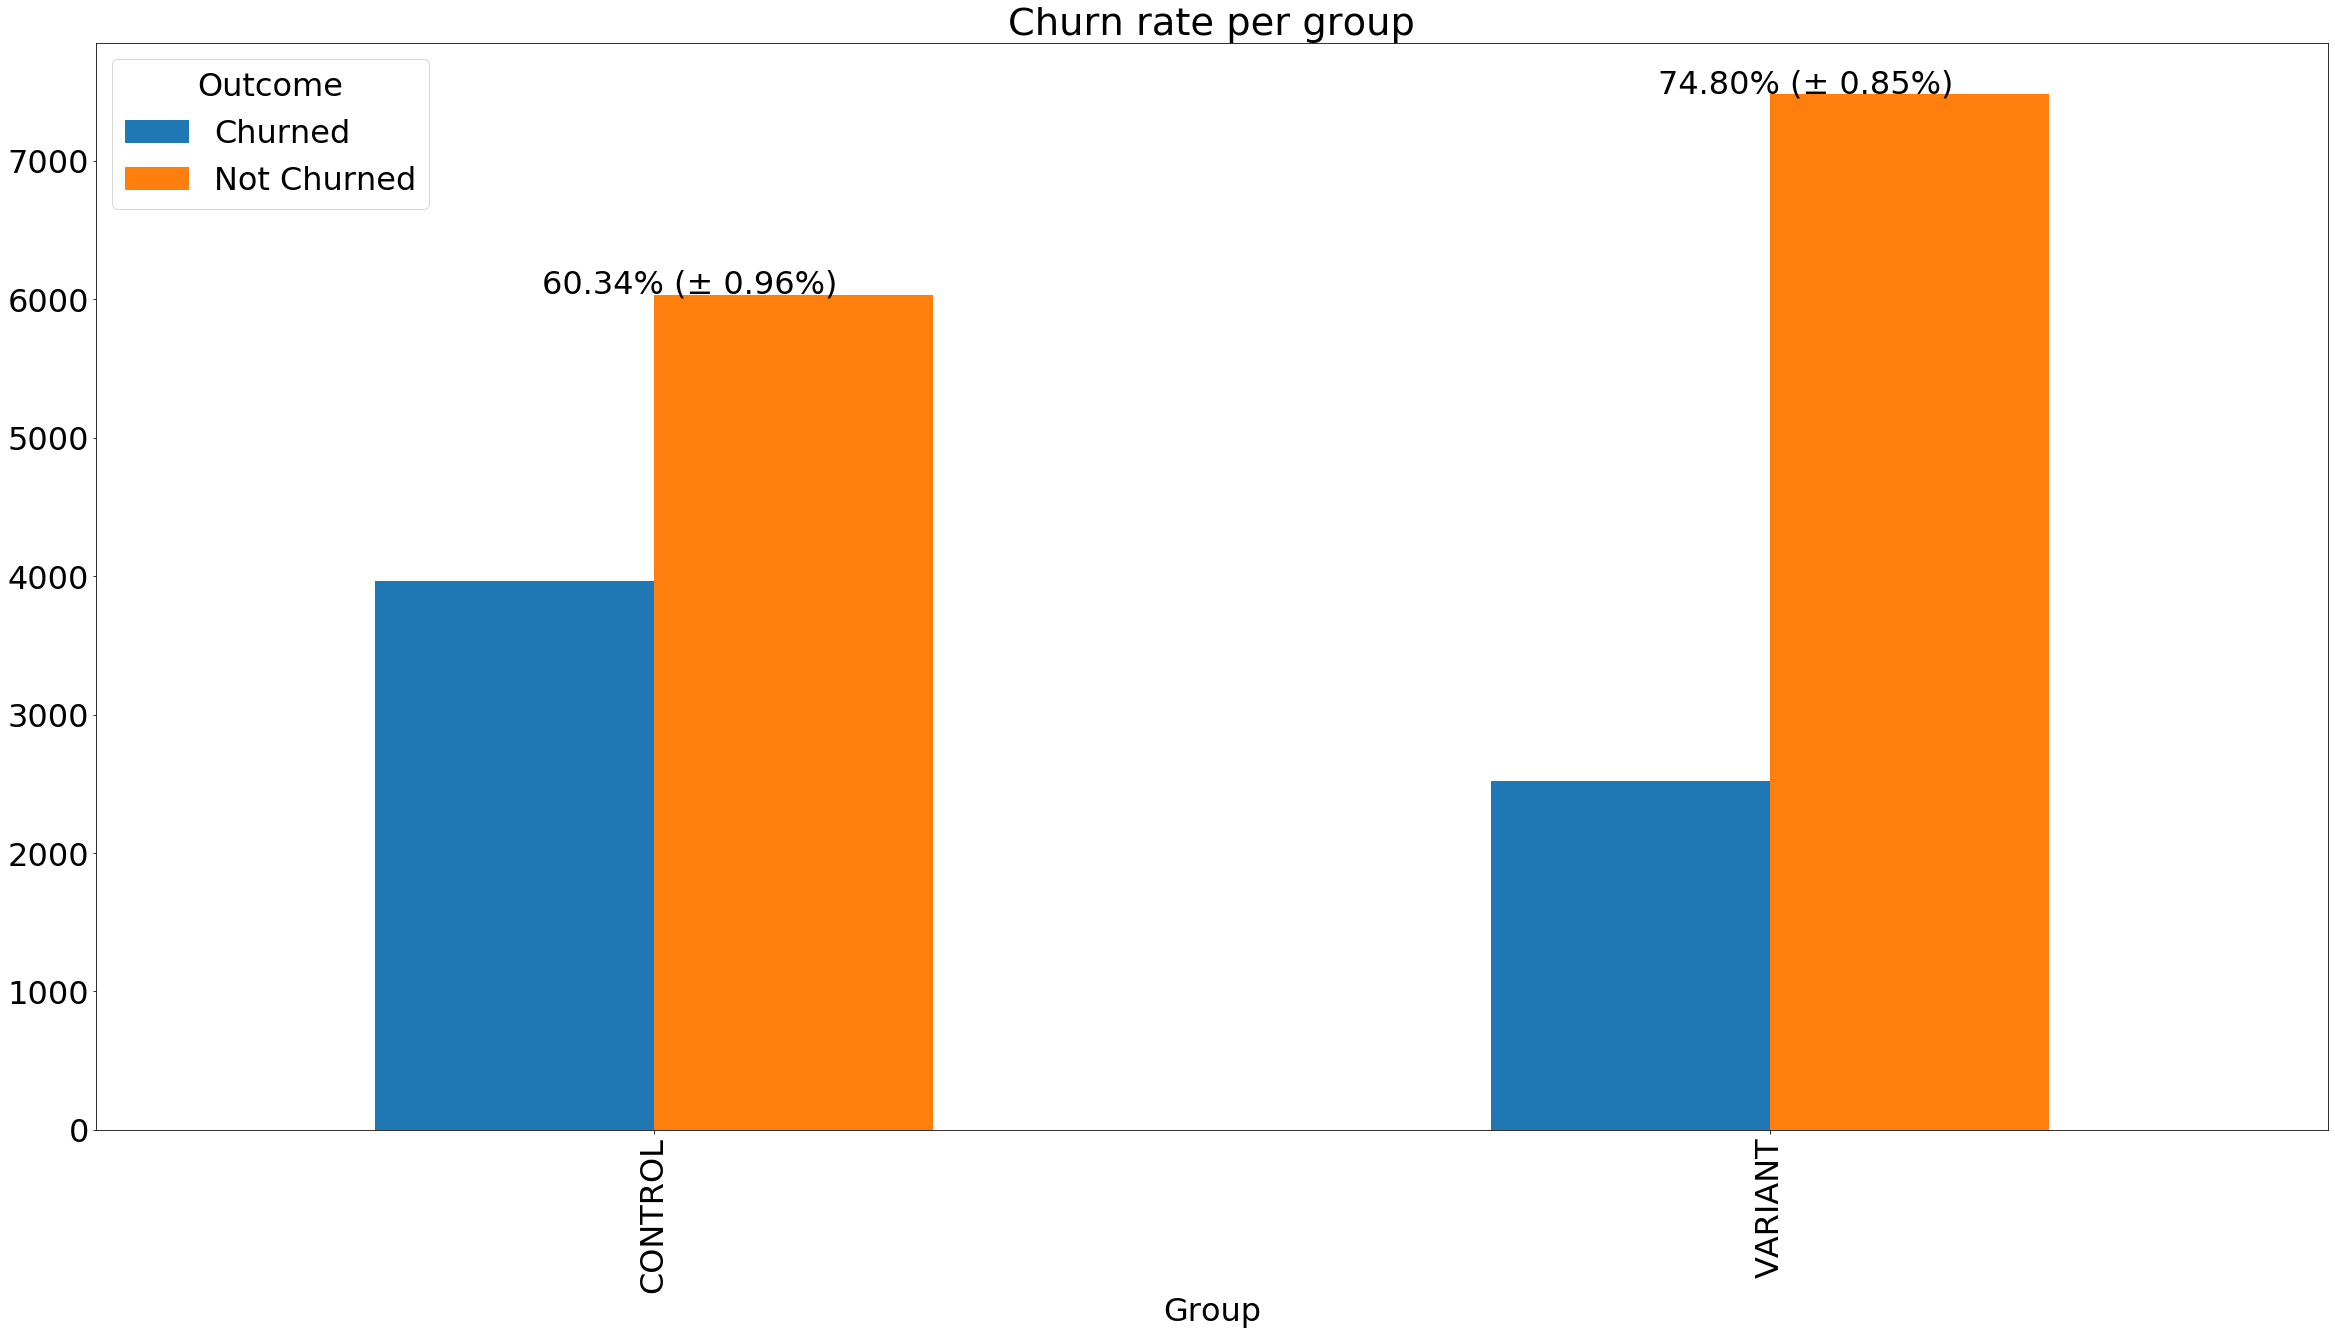

In [11]:
data = experiment_results.groupby(['Group','Outcome']).size().unstack()
ax = data.plot(kind='bar')
ax.set_title('Churn rate per group')

success_rates = experiment_results.groupby('Group').Outcome.value_counts(normalize=True).unstack()['Not Churned']

for index, rate in enumerate(success_rates):
    low_CI, upper_CI = proportion.proportion_confint(data.iloc[index]['Not Churned'], data.iloc[index].sum())
    ax.text(index - 0.1, data.iloc[index].max() + 10, '{:.2%} (± {:.2%})'.format(rate, (upper_CI-low_CI)/2))

I can already tell from the non overlapping conficende intervals in the picture that there is statistical significance. 

To double check I will calculate the `chi squared` and `p-value` and check the statistical significance.

In [13]:
obs = pd.crosstab(experiment_results.Group, experiment_results.Outcome).values
chi2, p, dof, ex = stats.chi2_contingency(obs, correction=False)

if p < 0.05:
    print('Results are significant! chi-value: {} p-value: {}'.format(chi2, p))
else:
    print('Results are not significant! chi-value: {} p-value: {}'.format(chi2, p))

Results are significant! chi-value: 477.0959420298982 p-value: 9.155122357120195e-106


### Further considerations
There are other methodologies available for calculating statistical significance of a A/B test, this is just the most basic and most common one. **Bayesian based methods** are also very effective methods to calculate A/B test significance. 

Furthermore, if we were to test multiple business actions at the same time, the best approach would be to use **multi armed bandit** based methodologies for A/B testing. A multi-armed bandit solution is a ‘smarter’ or more complex version of A/B testing that uses machine learning algorithms to dynamically allocate traffic to variations that are performing well, while allocating less traffic to variations that are underperforming. In theory, multi-armed bandits should produce faster results since there is no need to wait for a single winning variation.